In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
import statsmodels.tsa.api as tsa
from pmdarima.model_selection import train_test_split
from pmdarima.arima.utils import ndiffs, nsdiffs
# set random seed
SEED = 321
np.random.seed(SEED)

sns.set_context('notebook', font_scale=1.2)
plt.rcParams['figure.figsize']=(12,3)

In [2]:
def plot_forecast(ts_train, ts_test, forecast_df, n_train_lags=None, 
                  figsize=(10,4), title='Comparing Forecast vs. True Data'):
    ### PLot training data, and forecast (with upper/,lower ci)
    fig, ax = plt.subplots(figsize=figsize)

    # setting the number of train lags to plot if not specified
    if n_train_lags==None:
        n_train_lags = len(ts_train)
            
    # Plotting Training  and test data
    ts_train.iloc[-n_train_lags:].plot(ax=ax, label="train")
    ts_test.plot(label="test", ax=ax)

    # Plot forecast
    forecast_df['mean'].plot(ax=ax, color='green', label="forecast")

    # Add the shaded confidence interval
    ax.fill_between(forecast_df.index, 
                    forecast_df['mean_ci_lower'],
                   forecast_df['mean_ci_upper'],
                   color='green', alpha=0.3,  lw=2)

    # set the title and add legend
    ax.set_title(title)
    ax.legend();
    
    return fig, ax

In [3]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    # Get metrics
    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    rmse = mean_squared_error(ts_true, ts_pred, squared=False)
    r_squared = r2_score(ts_true, ts_pred)
    mae_perc = mean_absolute_percentage_error(ts_true, ts_pred) * 100

    if verbose == True:
        # Print Result with label
        header = "---" * 20
        print(header, f"Regression Metrics: {label}", header, sep="\n")
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
        print(f"- MAPE = {mae_perc:,.2f}%")

    if output_dict == True:
        metrics = {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r_squared,
            "MAPE(%)": mae_perc,
        }
        return metrics

In [4]:
# Custom function for Ad Fuller Test
def get_adfuller_results(ts, alpha=.05, label='adfuller', **kwargs): #kwargs for adfuller()
    # Saving each output
    (test_stat, pval, nlags, nobs, crit_vals_d, 
    icbest ) = tsa.adfuller(ts, **kwargs)
    # Converting output to a dictionary with the interpretation of p
    adfuller_results = {'Test Statistic': test_stat,
                        "# of Lags Used":nlags, 
                       '# of Observations':nobs,
                        'p-value': round(pval,6),
                        'alpha': alpha,
                       'sig/stationary?': pval < alpha}
    return pd.DataFrame(adfuller_results, index =[label])

In [5]:
def plot_acf_pacf(ts, nlags=40, figsize=(10, 5), 
                  annotate_sig=False, alpha=.05,
                 acf_kws={}, pacf_kws={},  
                  annotate_seas=False, m = None,
                 seas_color='black'):
    
    fig, axes = plt.subplots(nrows=2, figsize=figsize)

    
    # Sig lags line style
    sig_vline_kwargs = dict( ls=':', lw=1, zorder=0, color='red')

    # ACF
    tsa.graphics.plot_acf(ts, ax=axes[0], lags=nlags, **acf_kws)
    
    ## Annotating sig acf lags
    if annotate_sig == True:
        sig_acf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='ACF')
        for lag in sig_acf_lags:
            axes[0].axvline(lag,label='sig', **sig_vline_kwargs )

    # PACF
    tsa.graphics.plot_pacf(ts,ax=axes[1], lags=nlags, **pacf_kws)
    
    ## Annotating sig pacf lags
    if annotate_sig == True:
        ## ANNOTATING SIG LAGS
        sig_pacf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='PACF')
        for lag in sig_pacf_lags:
            axes[1].axvline(lag, label='sig', **sig_vline_kwargs)



    
    ### ANNOTATE SEASONS
    if annotate_seas == True:
        # Ensure m was defined
        if m is None:
            raise Exception("Must define value of m if annotate_seas=True.")

        ## Calculate number of complete seasons to annotate
        n_seasons = nlags//m 

        # Seasonal Lines style
        seas_vline_kwargs = dict( ls='--',lw=1, alpha=.7, color=seas_color, zorder=-1)
        
        ## for each season, add a line
        for i in range(1, n_seasons+1):
            axes[0].axvline(m*i, **seas_vline_kwargs, label="season")
            axes[1].axvline(m*i, **seas_vline_kwargs, label="season")

    fig.tight_layout()
    
    return fig

In [7]:
# Load data from statsmodels
import statsmodels.api as sm
co2_data = sm.datasets.co2.load_pandas()
df = co2_data.data
df.head()

,co2
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4


In [8]:
# Impute null values
df['co2'] = df['co2'].interpolate()
df.isna().sum().sum()

0

In [9]:
# Resample to monthly
ts = df.resample("M").mean()
ts.head()

,co2
1958-03-31,316.100
1958-04-30,317.200
1958-05-31,317.410
1958-06-30,316.675
1958-07-31,315.625


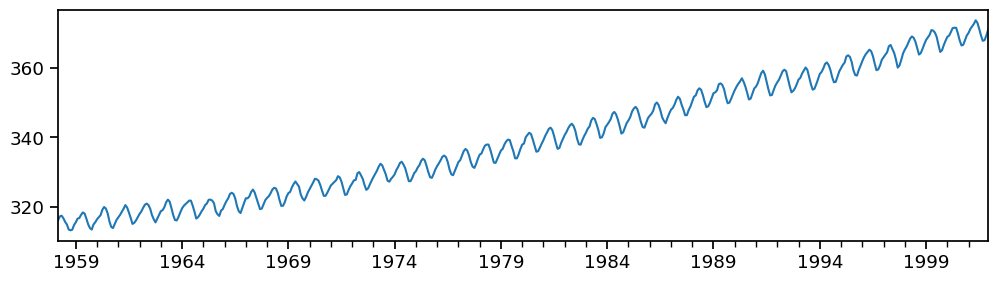

In [10]:
# Define the series
ts = ts['co2']
# Plot
ts.plot();

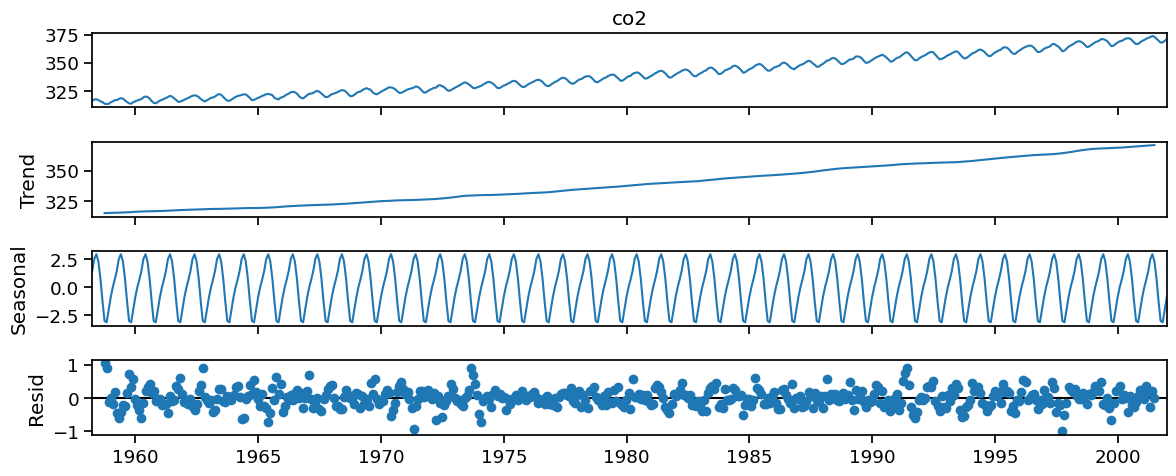

In [11]:
# We see a repeating pattern that is likely seasonal
# Apply seasonal decomposition
decomp = tsa.seasonal_decompose(ts)
fig = decomp.plot()
fig.set_size_inches(12,5)
fig.tight_layout();

In [12]:
# How big is the seasonal component
seasonal_delta = decomp.seasonal.max() - decomp.seasonal.min()

# How big is the seasonal component relative to the time series?
print(f"The seasonal component is {seasonal_delta} which is ~{seasonal_delta/(ts.max()-ts.min()) * 100 :.2f}% of the variation in time series.")

The seasonal component is 6.0652410580715355 which is ~10.01% of the variation in time series.


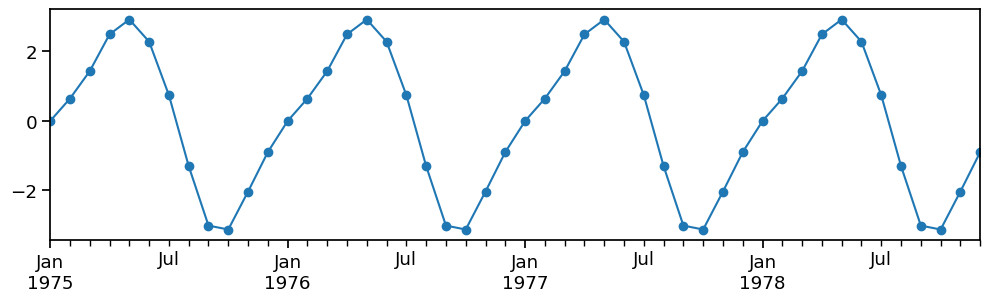

In [13]:
# Narrow down the date range of the plot
seasonal = decomp.seasonal
ax = seasonal.loc['1975': '1978'].plot(marker = 'o')

# SARIMA

In [14]:
# determine d
d = ndiffs(ts)
print (f'd = {d}')

d = 1


In [15]:
# Determine D
D = nsdiffs(ts, m =12)
print(f'D = {D}')

D = 0


In [17]:
# Difference the data
ts_diff = ts.diff().dropna()

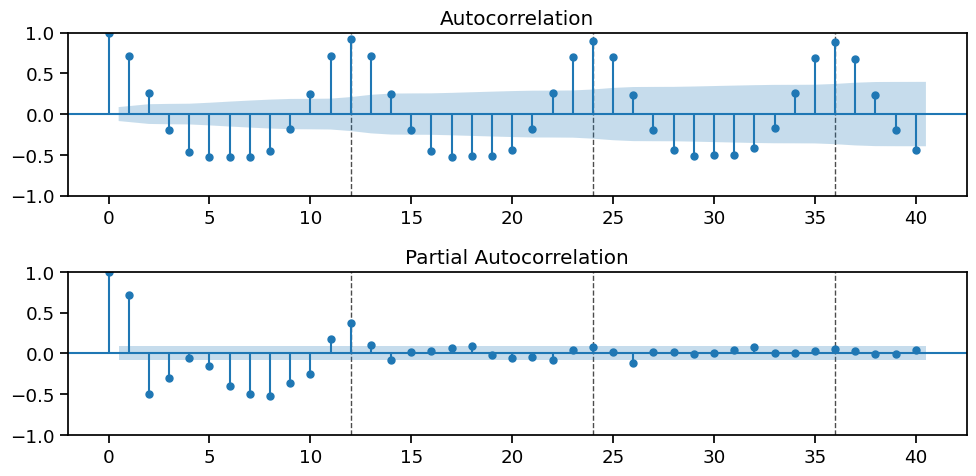

In [18]:
# We can use our function to highlight the seasonal lags by adding the arguments
plot_acf_pacf(ts_diff, annotate_seas=True, m = 12);

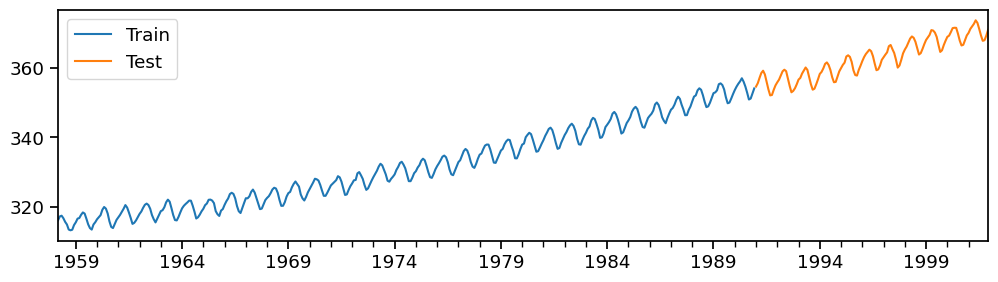

In [19]:
# tts
train, test = train_test_split(ts, test_size=.25)
ax = train.plot(label='Train')
test.plot(ax=ax, label='Test')
ax.legend();

In [20]:
# Orders for non seasonal components
p = 1  # nonseasonal AR
d = 1  # nonseasonal differencing
q = 1  # nonseasonal MA

# Orders for seasonal components
P = 1  # Seasonal AR
D = 0  # Seasonal differencing
Q = 1  # Seasonal MA
m = 12 # Seasonal period

sarima = tsa.ARIMA(train, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 0.807
- MSE = 0.976
- RMSE = 0.988
- R^2 = 0.969
- MAPE = 0.22%


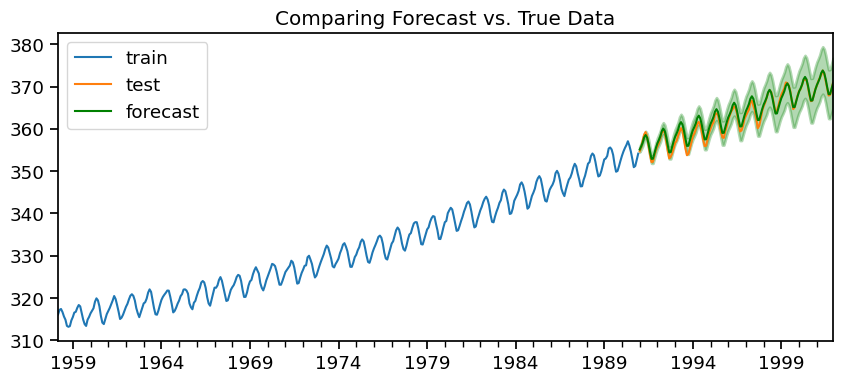

In [21]:
# Obtain summary of forecast as dataframe
forecast_df = sarima.get_forecast(len(test)).summary_frame()
# Plot the forecast with true values
plot_forecast(train, test, forecast_df)
# Obtain metrics
regression_metrics_ts(test, forecast_df["mean"])

In [22]:
# Obtain summary
sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                              co2   No. Observations:                  394
Model:             ARIMA(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -107.984
Date:                          Wed, 10 Jan 2024   AIC                            225.967
Time:                                  13:39:05   BIC                            245.836
Sample:                              03-31-1958   HQIC                           233.841
                                   - 12-31-1990                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4103      0.101      4.074      0.000       0.213       0.608
ma.L1         -0.7149      0.078     -9.143      0.000      -0.868      -0.562
ar.S.L12       0.9995      0.001   1907.431      0.000       0.998       1.001
ma.S.L12      -0.8538      0.034    -24.819      0.000      -0.921      -0.786
sigma2         0.0887      0.006     13.724      0.000       0.076       0.101
===================================================================================
Ljung-Box (L1) (Q):                   0.38   Jarque-Bera (JB):                 0.03
Prob(Q):                              0.54   Prob(JB):                         0.98
Heteroskedasticity (H):               0.81   Skew:                            -0.00
Prob(H) (two-sided):                  0.23   Kurtosis:                         3.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

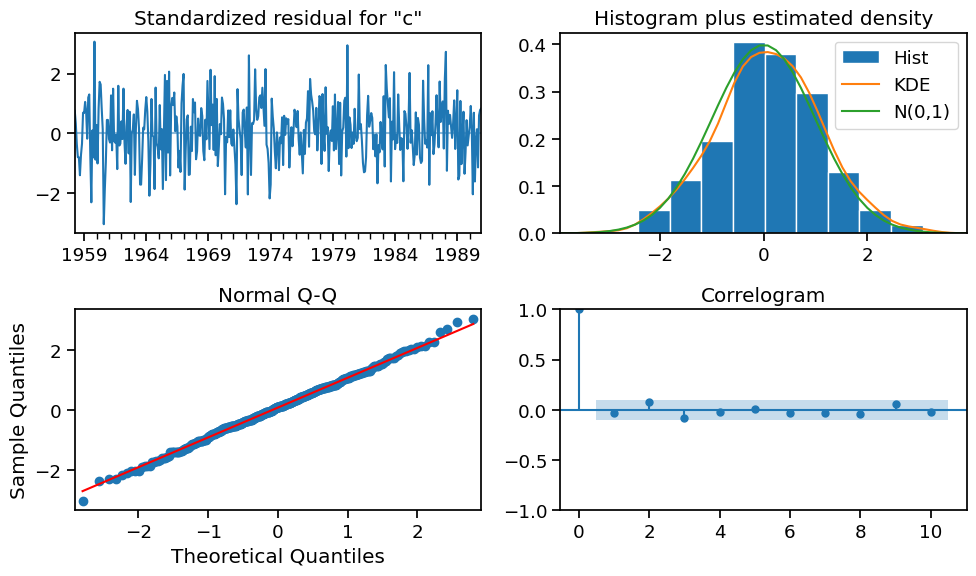

In [23]:
# Obtain diagnostic plots
fig = sarima.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

In [24]:
import itertools

# Define the value or range of values for p, d, q
p_values = range(0, 3)  
d_values = [1]          
q_values = range(0, 3)  
P_values = range (0, 3)
D_values = [0]
Q_values = range (0,3)
m = [12]

# Create combinations of pdq to test
pdqPDQm_to_try = list(itertools.product(p_values, d_values, q_values, P_values, D_values, Q_values, m))

# Display first 10 combinations
pdqPDQm_to_try[:10]

[(0, 1, 0, 0, 0, 0, 12),
 (0, 1, 0, 0, 0, 1, 12),
 (0, 1, 0, 0, 0, 2, 12),
 (0, 1, 0, 1, 0, 0, 12),
 (0, 1, 0, 1, 0, 1, 12),
 (0, 1, 0, 1, 0, 2, 12),
 (0, 1, 0, 2, 0, 0, 12),
 (0, 1, 0, 2, 0, 1, 12),
 (0, 1, 0, 2, 0, 2, 12),
 (0, 1, 1, 0, 0, 0, 12)]

In [25]:
# define starting aic as infinity
best_aic = float("inf")  

# define baseline for pdq
best_pdqPDQm = (0,0,0,0,0,0,0)

# Loop through each combination
for pdqPDQm in pdqPDQm_to_try:
    order = pdqPDQm[:3] # first three values are non seasonal (p,d,q)
    seasonal_order = pdqPDQm[3:] # Remaining values for seasonal (P,D,Q,m)
    
    model = tsa.ARIMA(train, order=order, seasonal_order = seasonal_order)
    try:                         
        result = model.fit()
        print(pdqPDQm, result.aic)      
   
    except:
        print(f'{pdqPDQm}: caused an error')
    
    # If lower, replace best AIC with new value
    if result.aic < best_aic:
        
        best_aic = result.aic
        best_pdqPDQm = pdqPDQm

# Print the best orders and AIC score
print("Best AIC:", best_aic)
print("Best pdqPDQm:", best_pdqPDQm)

(0, 1, 0, 0, 0, 0, 12) 1229.8364886351249
(0, 1, 0, 0, 0, 1, 12) 913.9222868846855
(0, 1, 0, 0, 0, 2, 12) 762.7178747733394
(0, 1, 0, 1, 0, 0, 12) 437.78554186117333
(0, 1, 0, 1, 0, 1, 12) 260.63481307331904
(0, 1, 0, 1, 0, 2, 12) 262.5305839679703
(0, 1, 0, 2, 0, 0, 12) 363.07061562745105
(0, 1, 0, 2, 0, 1, 12) 262.53684951344843
(0, 1, 0, 2, 0, 2, 12) 263.2360527615843
(0, 1, 1, 0, 0, 0, 12) 998.8592636683629
(0, 1, 1, 0, 0, 1, 12) 824.842337306975
(0, 1, 1, 0, 0, 2, 12) 734.2342957157094
(0, 1, 1, 1, 0, 0, 12) 405.7998349047059
(0, 1, 1, 1, 0, 1, 12) 231.70499099572407
(0, 1, 1, 1, 0, 2, 12) 233.7001096646967
(0, 1, 1, 2, 0, 0, 12) 331.7022152730386
(0, 1, 1, 2, 0, 1, 12) 233.70890317260665
(0, 1, 1, 2, 0, 2, 12) 234.3671714125957
(0, 1, 2, 0, 0, 0, 12) 894.5771694839272
(0, 1, 2, 0, 0, 1, 12) 758.1609034868953
(0, 1, 2, 0, 0, 2, 12) 683.0718561806798
(0, 1, 2, 1, 0, 0, 12) 405.39155420542386
(0, 1, 2, 1, 0, 1, 12) 230.1888144352984
(0, 1, 2, 1, 0, 2, 12) 232.18873800650476
(0, 1, 2

C:\Users\Rovidicus\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 1, 2, 2, 0, 0, 12) 322.1600260137142


C:\Users\Rovidicus\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 1, 2, 2, 0, 1, 12) 228.9981802456427
(1, 1, 2, 2, 0, 2, 12) 229.5953426435347
(2, 1, 0, 0, 0, 0, 12) 859.8419038982967
(2, 1, 0, 0, 0, 1, 12) 777.7957174089414
(2, 1, 0, 0, 0, 2, 12) 716.0002011573466
(2, 1, 0, 1, 0, 0, 12) 411.7522714488451
(2, 1, 0, 1, 0, 1, 12) 237.33368591054642
(2, 1, 0, 1, 0, 2, 12) 239.32228018586517
(2, 1, 0, 2, 0, 0, 12) 337.98056418011333
(2, 1, 0, 2, 0, 1, 12) 239.34179920151848
(2, 1, 0, 2, 0, 2, 12) 240.02929013819397
(2, 1, 1, 0, 0, 0, 12) 761.0503904355515
(2, 1, 1, 0, 0, 1, 12) 675.0623939573763
(2, 1, 1, 0, 0, 2, 12) 641.1927477859583
(2, 1, 1, 1, 0, 0, 12) 390.51213367727416


C:\Users\Rovidicus\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 1, 1, 0, 1, 12) 226.73814434212335
(2, 1, 1, 1, 0, 2, 12) 228.500082640295
(2, 1, 1, 2, 0, 0, 12) 321.9141254072455


C:\Users\Rovidicus\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 1, 2, 0, 1, 12) 228.55445749711168
(2, 1, 1, 2, 0, 2, 12) 229.13415638405348
(2, 1, 2, 0, 0, 0, 12) 762.4028939434139


C:\Users\Rovidicus\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 2, 0, 0, 1, 12) 546.1254514728718


C:\Users\Rovidicus\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 2, 0, 0, 2, 12) 489.801113250406
(2, 1, 2, 1, 0, 0, 12) 391.0690787958251


C:\Users\Rovidicus\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 2, 1, 0, 1, 12) 227.49458677623815


C:\Users\Rovidicus\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 2, 1, 0, 2, 12) 232.49798672196414


C:\Users\Rovidicus\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 2, 2, 0, 0, 12) 322.7223415644953


C:\Users\Rovidicus\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 2, 2, 0, 1, 12) 232.6741855693984


C:\Users\Rovidicus\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 2, 2, 0, 2, 12) 230.86629716513193
Best AIC: 225.96731983949581
Best pdqPDQm: (1, 1, 1, 1, 0, 1, 12)
